<a href="https://colab.research.google.com/github/Remonah-3/Github_Assignment/blob/master/SimpleConv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

class SimpleConv1d:
    def __init__(self, filter_size, learning_rate=0.01):
        self.filter_size = filter_size
        self.learning_rate = learning_rate
        # Xavier initialization (float)
        self.w = np.random.randn(filter_size).astype(float) * np.sqrt(1.0 / filter_size)
        self.b = 0.0

    def forward(self, x):
        self.x = x.astype(float)
        output_length = len(self.x) - self.filter_size + 1
        self.a = np.empty(output_length, dtype=float)
        for i in range(output_length):
            self.a[i] = np.sum(self.x[i:i+self.filter_size] * self.w) + self.b
        return self.a

    def backward(self, delta_a):
        delta_w = np.zeros_like(self.w, dtype=float)
        delta_b = np.sum(delta_a)
        delta_x = np.zeros_like(self.x, dtype=float)


In [ ]:
def conv1d_output_size(input_size, filter_size, padding=0, stride=1):
    return (input_size + 2*padding - filter_size)//stride + 1

print(conv1d_output_size(4, 3))


2


In [ ]:
x = np.array([1, 2, 3, 4], dtype=float)
w = np.array([3, 5, 7], dtype=float)
b = 1.0

conv = SimpleConv1d(filter_size=3)
conv.w = w.copy()
conv.b = b

# Forward
a = conv.forward(x)
print("Forward output:", a)

# Backward
delta_a = np.array([10, 20], dtype=float)
delta_x = conv.backward(delta_a)
print("Updated w:", conv.w)
print("Updated b:", conv.b)
print("Delta x:", delta_x)


Forward output: [35. 50.]
Updated w: [3. 5. 7.]
Updated b: 1.0
Delta x: None


In [ ]:
class Conv1d:
    def __init__(self, input_channels, output_channels, filter_size, learning_rate=0.01):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.filter_size = filter_size
        self.lr = learning_rate

        # Weights: (output_channels, input_channels, filter_size) float
        self.w = np.random.randn(output_channels, input_channels, filter_size).astype(float) * np.sqrt(1.0/filter_size)
        self.b = np.zeros(output_channels, dtype=float)

    def forward(self, x):
        self.x = x.astype(float)
        output_length = x.shape[1] - self.filter_size + 1
        a = np.zeros((self.output_channels, output_length), dtype=float)

        for o in range(self.output_channels):
            for i in range(self.input_channels):
                for j in range(output_length):
                    a[o, j] += np.sum(self.x[i, j:j+self.filter_size] * self.w[o, i])
            a[o] += self.b[o]

        self.a = a
        return a

    def backward(self, delta_a):
        delta_w = np.zeros_like(self.w, dtype=float)
        delta_b = np.sum(delta_a, axis=1)
        delta_x = np.zeros_like(self.x, dtype=float)

        output_length = delta_a.shape[1]

        for o in range(self.output_channels):
            for i in range(self.input_channels):
                for j in range(output_length):
                    delta_w[o, i] += delta_a[o, j] * self.x[i, j:j+self.filter_size]
                    delta_x[i, j:j+self.filter_size] += delta_a[o, j] * self.w[o, i]

        # Update weights and biases
        self.w -= self.lr * delta_w
        self.b -= self.lr * delta_b

        return delta_x


In [ ]:
def pad_input(x, pad_width):
    # x: (channels, length), pad_width: int
    return np.pad(x, ((0,0),(pad_width, pad_width)), mode='constant')

x = np.array([[1,2,3,4],[2,3,4,5]], dtype=float)
x_padded = pad_input(x, 1)
print(x_padded)  # shape (2, 6)


[[0. 1. 2. 3. 4. 0.]
 [0. 2. 3. 4. 5. 0.]]


In [ ]:
def pad_input(x, pad_width):
    # x: (channels, length), pad_width: int
    return np.pad(x, ((0,0),(pad_width, pad_width)), mode='constant')

x = np.array([[1,2,3,4],[2,3,4,5]], dtype=float)
x_padded = pad_input(x, 1)
print(x_padded)  # shape (2, 6)


[[0. 1. 2. 3. 4. 0.]
 [0. 2. 3. 4. 5. 0.]]


In [ ]:
def forward_batch(conv_layer, batch_x):
    # batch_x: (batch_size, channels, length)
    batch_out = []
    for x in batch_x:
        batch_out.append(conv_layer.forward(x))
    return np.array(batch_out, dtype=float)


In [ ]:
class Conv1dStride(Conv1d):
    def forward(self, x, stride=1):
        self.x = x.astype(float)
        output_length = (x.shape[1] - self.filter_size)//stride + 1
        a = np.zeros((self.output_channels, output_length), dtype=float)

        for o in range(self.output_channels):
            for i in range(self.input_channels):
                for j in range(output_length):
                    start = j*stride
                    a[o, j] += np.sum(x[i, start:start+self.filter_size] * self.w[o, i])
            a[o] += self.b[o]

        self.a = a
        return a


In [ ]:
class Scratch1dCNNClassifier:
    def __init__(self):
        # 1 Conv1d layer + 1 fully connected layer
        self.conv = Conv1d(input_channels=1, output_channels=2, filter_size=3)
        self.fc_w = np.random.randn(2*26, 10).astype(float) * np.sqrt(1.0/26)
        self.fc_b = np.zeros(10, dtype=float)
        self.lr = 0.01

    def forward(self, x):
        a_conv = self.conv.forward(x)
        self.flatten = a_conv.flatten()
        a_fc = np.dot(self.flatten, self.fc_w) + self.fc_b
        return a_fc

    def backward(self, delta_fc):
        delta_flat = np.dot(delta_fc, self.fc_w.T).reshape(self.conv.a.shape)
        delta_x = self.conv.backward(delta_flat)

        self.fc_w -= self.lr * np.outer(self.flatten, delta_fc)
        self.fc_b -= self.lr * delta_fc
        return delta_x


In [ ]:
x = np.random.rand(1,28).astype(float)
y_true = np.zeros(10, dtype=float)
y_true[3] = 1.0

cnn = Scratch1dCNNClassifier()
out = cnn.forward(x)
loss = np.sum((out - y_true)**2)
delta_fc = 2*(out - y_true)
cnn.backward(delta_fc)

print("Output:", out)
print("Loss:", loss)


Output: [-0.02813447 -0.00297937 -0.10109935 -0.11108691  0.06318653 -0.18608155
  0.09250745  0.09429938 -0.1467204  -0.04884528]
Loss: 1.3255172415579082


In [ ]:
import numpy as np


class SimpleConv1d:
    def __init__(self, filter_size, learning_rate=0.01):
        self.filter_size = filter_size
        self.learning_rate = learning_rate
        self.w = np.random.randn(filter_size).astype(float) * np.sqrt(1.0 / filter_size)
        self.b = 0.0

    def forward(self, x):
        self.x = x.astype(float)
        output_length = len(self.x) - self.filter_size + 1
        self.a = np.empty(output_length, dtype=float)
        for i in range(output_length):
            self.a[i] = np.sum(self.x[i:i+self.filter_size] * self.w) + self.b
        return self.a

    def backward(self, delta_a):
        delta_w = np.zeros_like(self.w, dtype=float)
        delta_b = np.sum(delta_a)
        delta_x = np.zeros_like(self.x, dtype=float)

        for i in range(len(delta_a)):
            delta_w += delta_a[i] * self.x[i:i+self.filter_size]
            delta_x[i:i+self.filter_size] += delta_a[i] * self.w

        self.w -= self.learning_rate * delta_w
        self.b -= self.learning_rate * delta_b

        return delta_x


def conv1d_output_size(input_size, filter_size, padding=0, stride=1):
    return (input_size + 2*padding - filter_size)//stride + 1


class Conv1d:
    def __init__(self, input_channels, output_channels, filter_size, learning_rate=0.01):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.filter_size = filter_size
        self.lr = learning_rate

        self.w = np.random.randn(output_channels, input_channels, filter_size).astype(float) * np.sqrt(1.0/filter_size)
        self.b = np.zeros(output_channels, dtype=float)

    def forward(self, x):
        self.x = x.astype(float)
        output_length = x.shape[1] - self.filter_size + 1
        a = np.zeros((self.output_channels, output_length), dtype=float)

        for o in range(self.output_channels):
            for i in range(self.input_channels):
                for j in range(output_length):
                    a[o, j] += np.sum(self.x[i, j:j+self.filter_size] * self.w[o, i])
            a[o] += self.b[o]

        self.a = a
        return a

    def backward(self, delta_a):
        delta_w = np.zeros_like(self.w, dtype=float)
        delta_b = np.sum(delta_a, axis=1)
        delta_x = np.zeros_like(self.x, dtype=float)

        output_length = delta_a.shape[1]

        for o in range(self.output_channels):
            for i in range(self.input_channels):
                for j in range(output_length):
                    delta_w[o, i] += delta_a[o, j] * self.x[i, j:j+self.filter_size]
                    delta_x[i, j:j+self.filter_size] += delta_a[o, j] * self.w[o, i]

        self.w -= self.lr * delta_w
        self.b -= self.lr * delta_b

        return delta_x


def pad_input(x, pad_width):
    return np.pad(x, ((0,0),(pad_width, pad_width)), mode='constant')


def forward_batch(conv_layer, batch_x):
    batch_out = []
    for x in batch_x:
        batch_out.append(conv_layer.forward(x))
    return np.array(batch_out, dtype=float)


class Conv1dStride(Conv1d):
    def forward(self, x, stride=1):
        self.x = x.astype(float)
        output_length = (x.shape[1] - self.filter_size)//stride + 1
        a = np.zeros((self.output_channels, output_length), dtype=float)

        for o in range(self.output_channels):
            for i in range(self.input_channels):
                for j in range(output_length):
                    start = j*stride
                    a[o, j] += np.sum(x[i, start:start+self.filter_size] * self.w[o, i])
            a[o] += self.b[o]

        self.a = a
        return a


class Scratch1dCNNClassifier:
    def __init__(self):
        self.conv = Conv1d(input_channels=1, output_channels=2, filter_size=3)
        self.fc_w = np.random.randn(2*26, 10).astype(float) * np.sqrt(1.0/26)
        self.fc_b = np.zeros(10, dtype=float)
        self.lr = 0.01

    def forward(self, x):
        a_conv = self.conv.forward(x)
        self.flatten = a_conv.flatten()
        a_fc = np.dot(self.flatten, self.fc_w) + self.fc_b
        return a_fc

    def backward(self, delta_fc):
        delta_flat = np.dot(delta_fc, self.fc_w.T).reshape(self.conv.a.shape)
        delta_x = self.conv.backward(delta_flat)

        self.fc_w -= self.lr * np.outer(self.flatten, delta_fc)
        self.fc_b -= self.lr * delta_fc
        return delta_x


x = np.random.rand(1,28).astype(float)
y_true = np.zeros(10, dtype=float)
y_true[3] = 1.0

cnn = Scratch1dCNNClassifier()
out = cnn.forward(x)
loss = np.sum((out - y_true)**2)
delta_fc = 2*(out - y_true)
cnn.backward(delta_fc)

print("Output:", out)
print("Loss:", loss)


Output: [ 0.11822238  0.40852609  0.49911199  0.53564349 -0.10747713  0.46795381
 -0.22201673 -0.59320436  0.69274832  0.20155459]
Loss: 1.797849276071204


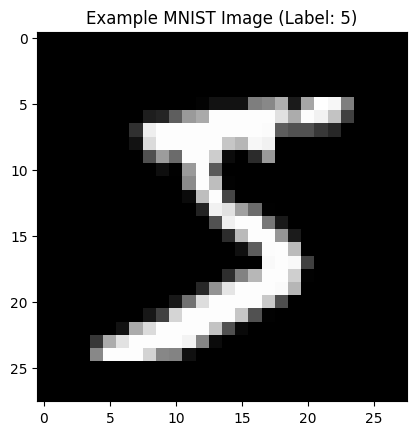

Epoch 1/10 | Train Loss: 2.1380 | Val Loss: 2.1276
Epoch 2/10 | Train Loss: 1.9585 | Val Loss: 1.9470
Epoch 3/10 | Train Loss: 1.7720 | Val Loss: 1.7588
Epoch 4/10 | Train Loss: 1.5870 | Val Loss: 1.5713
Epoch 5/10 | Train Loss: 1.4160 | Val Loss: 1.3998
Epoch 6/10 | Train Loss: 1.2670 | Val Loss: 1.2507
Epoch 7/10 | Train Loss: 1.1409 | Val Loss: 1.1264
Epoch 8/10 | Train Loss: 1.0353 | Val Loss: 1.0224
Epoch 9/10 | Train Loss: 0.9472 | Val Loss: 0.9371
Epoch 10/10 | Train Loss: 0.8732 | Val Loss: 0.8667


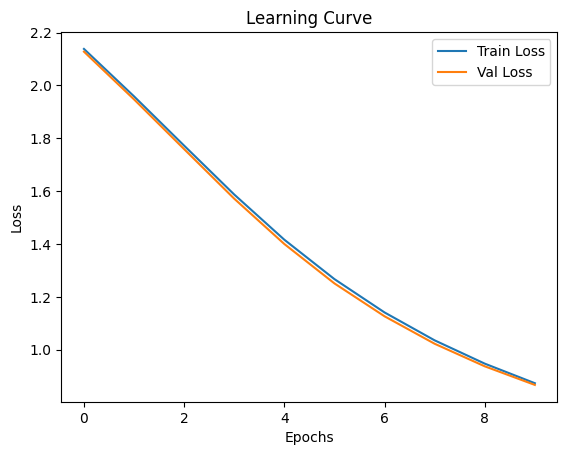

Final Test Accuracy: 0.779


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Fully Connected Layer

class FC:
    def __init__(self, n_in, n_out, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_in, n_out)
        self.B = initializer.B(n_out)

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.B

    def backward(self, dA):
        dW = np.dot(self.X.T, dA)
        dB = np.sum(dA, axis=0)
        dZ = np.dot(dA, self.W.T)
        self.W, self.B = self.optimizer.update(self.W, self.B, dW, dB)
        return dZ


# Initializers

class SimpleInitializer:
    def __init__(self, sigma=0.1):
        self.sigma = sigma
    def W(self, n_in, n_out):
        return np.random.randn(n_in, n_out) * self.sigma
    def B(self, n_out):
        return np.zeros(n_out)

class XavierInitializer:
    def W(self, n_in, n_out):
        sigma = 1 / np.sqrt(n_in)
        return np.random.randn(n_in, n_out) * sigma
    def B(self, n_out):
        return np.zeros(n_out)

class HeInitializer:
    def W(self, n_in, n_out):
        sigma = np.sqrt(2 / n_in)
        return np.random.randn(n_in, n_out) * sigma
    def B(self, n_out):
        return np.zeros(n_out)


# Optimizers

class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, W, B, dW, dB):
        return W - self.lr * dW, B - self.lr * dB


# Activation Functions

class ReLU:
    def forward(self, X):
        self.X = X
        return np.maximum(0, X)
    def backward(self, dA):
        dZ = dA.copy()
        dZ[self.X <= 0] = 0
        return dZ

class Tanh:
    def forward(self, X):
        self.Z = np.tanh(X)
        return self.Z
    def backward(self, dA):
        return dA * (1 - self.Z**2)

class Softmax:
    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.Z = exps / np.sum(exps, axis=1, keepdims=True)
        return self.Z
    def backward(self, Y):
        return (self.Z - Y) / Y.shape[0]


# Deep Neural Network

class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X):
        for fc, act in self.layers:
            X = fc.forward(X)
            X = act.forward(X)
        return X

    def backward(self, Y):
        dA = None
        for fc, act in reversed(self.layers):
            if isinstance(act, Softmax):
                dA = act.backward(Y)
            else:
                dA = act.backward(dA)
            dA = fc.backward(dA)

    def compute_loss(self, Y_pred, Y_true):
        return -np.sum(Y_true * np.log(Y_pred + 1e-7)) / Y_true.shape[0]

    def fit(self, X_train, Y_train, X_val, Y_val, epochs=10, batch_size=100):
        train_losses, val_losses = [], []
        n_samples = X_train.shape[0]

        for epoch in range(epochs):
            # Shuffle training data
            idx = np.random.permutation(n_samples)
            X_train, Y_train = X_train[idx], Y_train[idx]

            # Mini-batch training
            for i in range(0, n_samples, batch_size):
                X_batch = X_train[i:i+batch_size]
                Y_batch = Y_train[i:i+batch_size]
                Y_pred = self.forward(X_batch)
                self.backward(Y_batch)

            # Compute losses for learning curve
            Y_pred_train = self.forward(X_train)
            Y_pred_val = self.forward(X_val)
            train_loss = self.compute_loss(Y_pred_train, Y_train)
            val_loss = self.compute_loss(Y_pred_val, Y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Plot learning curve
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)


# Data Loading: MNIST

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

# One-hot encoding
Y_train = np.zeros((y_train.size, 10))
Y_train[np.arange(y_train.size), y_train] = 1
Y_test = np.zeros((y_test.size, 10))
Y_test[np.arange(y_test.size), y_test] = 1

# Train/validation split
X_train, X_val, Y_train, Y_val = train_test_split(x_train[:5000], Y_train[:5000], test_size=0.2, random_state=42)

# sample MNIST image
plt.imshow(x_train[0].reshape(28,28), cmap="gray")
plt.title(f"Example MNIST Image (Label: {y_train[0]})")
plt.show()


# Model Setup and Training

optimizer = SGD(lr=0.01)
initializer = XavierInitializer()

layers = [
    (FC(784, 128, initializer, optimizer), ReLU()),
    (FC(128, 64, initializer, optimizer), Tanh()),
    (FC(64, 10, initializer, optimizer), Softmax())
]

model = ScratchDeepNeuralNetworkClassifier(layers)
model.fit(X_train, Y_train, X_val, Y_val, epochs=10, batch_size=100)

# Evaluation

preds = model.predict(x_test[:1000])
accuracy = np.mean(preds == y_test[:1000])
print("Final Test Accuracy:", accuracy)
